In [42]:
from typing import Tuple, Dict
import cv2
import numpy as np
from PIL import Image
from ultralytics.yolo.utils.plotting import colors


def plot_one_box(box:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, mask:np.ndarray = None, label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        mask (np.ndarray, *optional*, None): instance segmentation mask polygon in format [N, 2], where N - number of points in contour, if not provided, only box will be drawn
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    if mask is not None:
        image_with_mask = img.copy()
        mask
        cv2.fillPoly(image_with_mask, pts=[mask.astype(int)], color=color)
        img = cv2.addWeighted(img, 0.5, image_with_mask, 0.5, 1)
    return img


def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:
        
    """
    boxes = results["det"]
    masks = results.get("segment")
    h, w = source_image.shape[:2]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f'{label_map[int(lbl)]} {conf:.2f}'
        mask = masks[idx] if masks is not None else None
        source_image = plot_one_box(xyxy, source_image, mask=mask, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

In [43]:
from ultralytics import YOLO

DET_MODEL_NAME = "yolov8n"

det_model = YOLO(f'{DET_MODEL_NAME}.pt')
label_map = det_model.model.names

In [44]:
device = "CPU"

In [45]:
from pathlib import Path
 
# object detection model
det_model_path = Path(f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml")
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=False)

In [46]:
from openvino.runtime import Core, Model

core = Core()
det_ov_model = core.read_model(det_model_path)
device = "CPU"  # "GPU"
if device != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
det_compiled_model = core.compile_model(det_ov_model, device)


def detect(image:np.ndarray, model:Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    num_outputs = len(model.outputs)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    masks = None
    if num_outputs > 1:
        masks = result[model.output(1)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image, pred_masks=masks)
    return detections

In [47]:
from typing import Tuple
from ultralytics.yolo.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input, 
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints
    
    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size
    
    
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]
    
    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range 
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

In [48]:
def postprocess(
    pred_boxes:np.ndarray, 
    input_hw:Tuple[int, int], 
    orig_img:np.ndarray, 
    min_conf_threshold:float = 0.25, 
    nms_iou_threshold:float = 0.7, 
    agnosting_nms:bool = False, 
    max_detections:int = 300,
    pred_masks:np.ndarray = None,
    retina_mask:bool = False
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
        pred_masks (np.ndarray, *optional*, None): model ooutput prediction masks, if not provided only boxes will be postprocessed
        retina_mask (bool, *optional*, False): retina mask postprocessing instead of native decoding
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label] and segment - segmentation polygons for each element in batch
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    # if pred_masks is not None:
    #     nms_kwargs["nm"] = 32
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=80,
        **nms_kwargs
    )
    results = []
    proto = torch.from_numpy(pred_masks) if pred_masks is not None else None

    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        if proto is None:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            results.append({"det": pred})
            continue
        if retina_mask:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], shape[:2])  # HWC
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], input_hw, upsample=True)
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        results.append({"det": pred[:, :6].numpy(), "segment": segments})
    return results

In [49]:
import sys
import collections
import time
from IPython import display
sys.path.append("../utils")
import notebook_utils as utils


# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0, model=det_model, device=device):
    player = None
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect(input_image[:, :, ::-1], compiled_model)[0]
            stop_time = time.time()
            
            image_with_boxes = draw_results(detections, input_image, label_map)
            frame = image_with_boxes
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

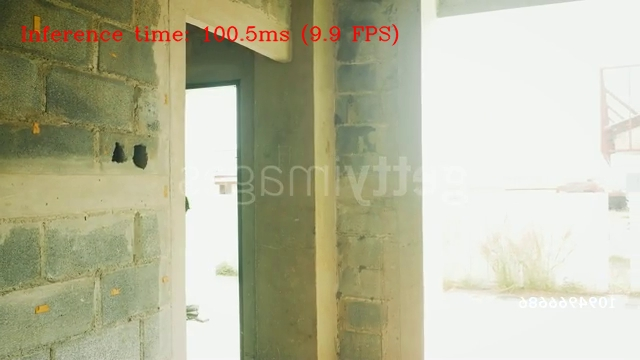

Source ended


In [50]:
run_object_detection(source="../../../videos_for_testing/gettyimages-1094966686-640_adpp.mp4", 
                     flip=True, use_popup=False, model="yolov8n.onnx", device=device)

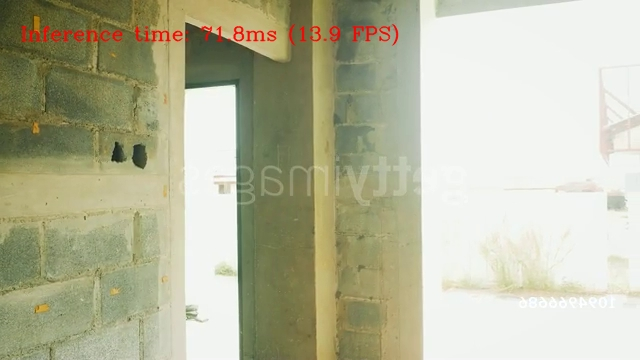

Source ended


In [55]:
run_object_detection(source="../../../videos_for_testing/gettyimages-1094966686-640_adpp.mp4", 
                     flip=True, use_popup=False, model="yolov8n_openvino_int8_model/yolov8n.xml", device=device)